In [3]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/m7/d_1f6t111ksdtr99n9zf9fjh0000gp/T/ipykernel_49688/3574156891.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
true_vals=[38.94801652652866,193.4015439096185,52.24130352947285,30.52123007653054,39.231588311273846,34.86007101736975,0.1902661176643755,0.28113643328037285,0.8181176651249633,4.758094367378883,1.985417765709296,4.910007465597671,24.68491191280538,29.42387320898578,41.04934603816582,1.1977430229572492,1.5302375124759988,1.5608364378206137,0.7747339528650133,0.7511393265314563,0.7528339378453786]
len(true_vals)

21

In [5]:
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1,k2,k3=params
    #for now we are setting a, g, n, b dm, dp to be constant
    a1,a2,a3,g1,g2,g3,n1,n2,n3,b1,b2,b3,dm1,dm2,dm3,dp1,dp2,dp3 = true_vals[3:]
    dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
    dp1dt = (b1*m1) - (dp1*p1)
    dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
    dp2dt = (b2*m2) - (dp2*p2)
    dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
    dp3dt = (b3*m3)-(dp3*p3)
    return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt])

In [6]:
def model_15p(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1,k2,k3,a1,a2,a3,g1,g2,g3,n1,n2,n3,b1,b2,b3=params
    #for now we are setting a, g, n, b dm, dp to be constant
    dm1,dm2,dm3,dp1,dp2,dp3 = true_vals[15:]
    dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
    dp1dt = (b1*m1) - (dp1*p1)
    dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
    dp2dt = (b2*m2) - (dp2*p2)
    dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
    dp3dt = (b3*m3)-(dp3*p3)
    return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt])

In [7]:
def solve_ode(params):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3])
    solution = odeint(model, initial_conditions, t=np.linspace(0,100,100), args=(params,)) # The initial value point should be the first element of this sequence
    return solution

In [8]:
def solve_ode_15p(params):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3])
    solution = odeint(model_15p, initial_conditions, t=np.linspace(0,100,100), args=(params,)) # The initial value point should be the first element of this sequence
    return solution

In [9]:
param_vals_3p_5_3000 = pd.read_csv('3p-5_3000_posterior_samples.csv',index_col=0)
param_vals_3p_10_1500 = pd.read_csv('3p-10_1500_posterior_samples.csv',index_col=0)
param_vals_15p_flattened= pd.read_csv('15p-10_1500_posterior_samples.csv',index_col=0)
param_vals_15p_sumstats=pd.read_csv('15p-10_1500_norm_ss_posterior_samples.csv',index_col=0)

In [10]:
toy=param_vals_3p_10_1500.iloc[:100]

In [11]:
median_5_3000=param_vals_3p_5_3000.median(axis=0) #median of the posterior samples
median_10_1500=param_vals_3p_10_1500.median(axis=0) #median of the posterior samples

In [12]:
def generate_traj(param_values):
    # param values imported from csv
    dim=np.shape(param_values)[0] # number of samples
    raw_trajectories=np.zeros([dim,100,6]) #first dim:no of samples, 100 time points, 6 trajec
    if np.shape(param_values)[1]==3:
        for i in range(dim):
            raw_trajectories[i]=solve_ode(param_values.iloc[i]).reshape(100,6)
    elif np.shape(param_values)[1]==15:
        for i in range(dim):
            raw_trajectories[i]=solve_ode_15p(param_values.iloc[i]).reshape(100,6)
    tr=np.percentile(raw_trajectories, [2.5, 97.5], axis=0) 
    return(tr)

In [13]:
x_o=solve_ode([38.94801652652866,193.4015439096185,52.24130352947285])

In [14]:
def plot_ppc(tr,true_trajectories):
    titles=["m1","p1","m2","p2", "m3", "p3"]
    fig, ax=plt.subplots(3,2,figsize=(15,9))
    ax = ax.ravel()
    for i in range(6):
        for j in range(2):
            ax[i].plot(np.linspace(0,100,100),tr[j,:,i],alpha=0.4,linestyle='dotted',linewidth=1,color='black')
        ax[i].plot(np.linspace(0,100,100),true_trajectories.reshape(100,6)[:,i],linewidth=0.6,color='black')
        ax[i].set_title(titles[i])
        ax[i].fill_between(np.linspace(0,100,100),tr[0, :, i],tr[1, :, i],alpha=0.4,color='skyblue')

In [15]:
def ppc(param_values,title):
    tr=generate_traj(param_values)
    plot_ppc(tr,x_o)
    plt.savefig(f'{title}_ppc.png',dpi=700)

In [16]:
ppc(param_vals_3p_10_1500,"10round_1500samples")

KeyboardInterrupt: 

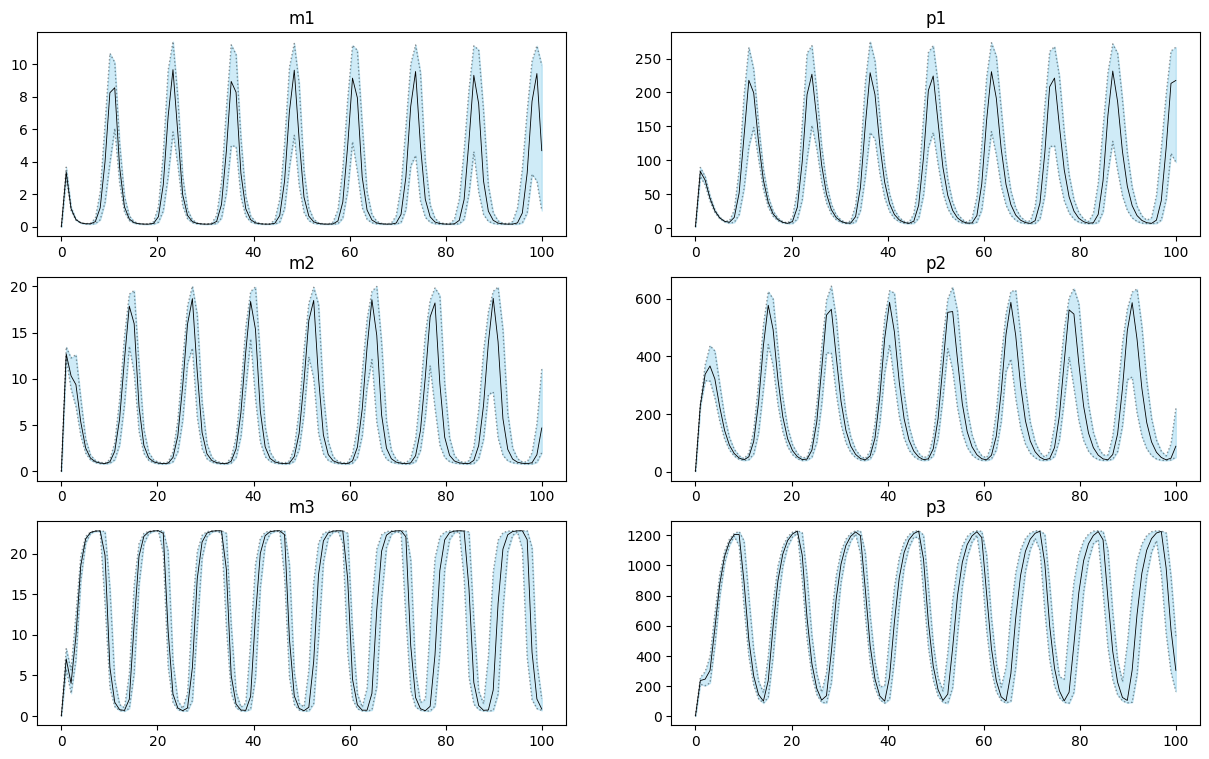

In [15]:
ppc(param_vals_3p_5_3000,"5round_3000samples")

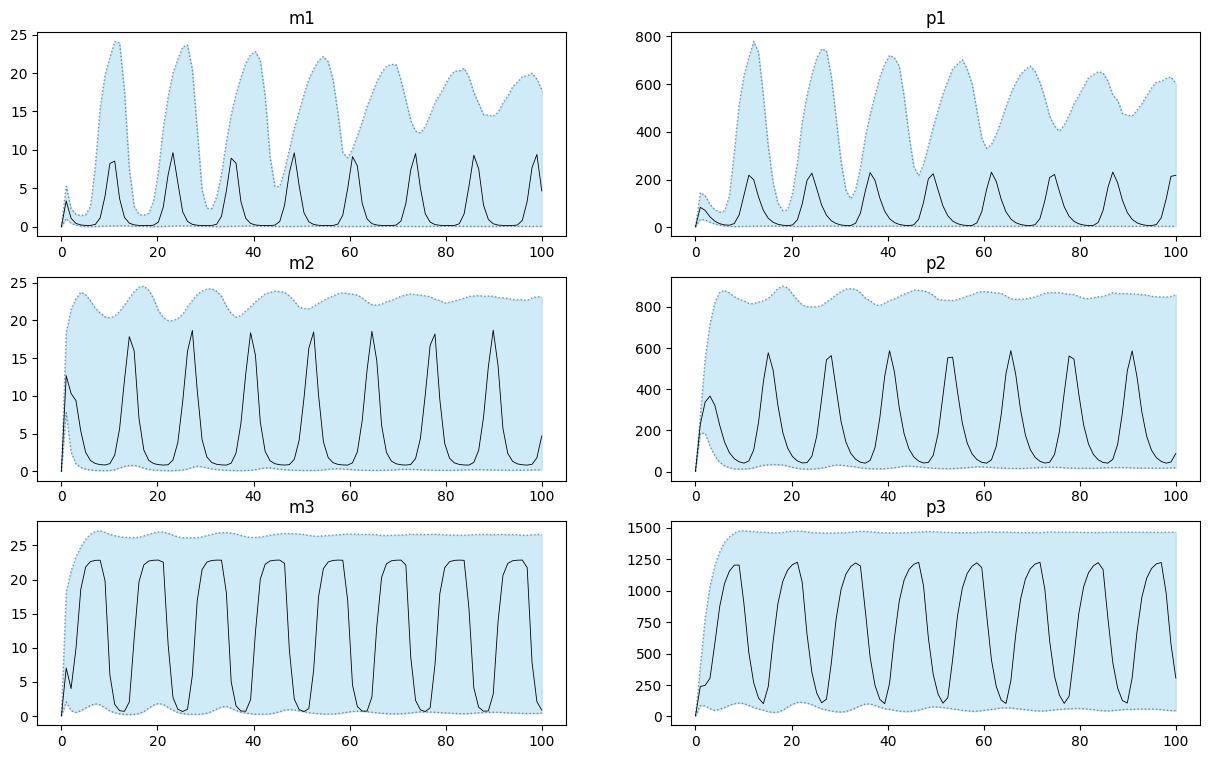

In [16]:
ppc(param_vals_15p_flattened,"15p_flattened")

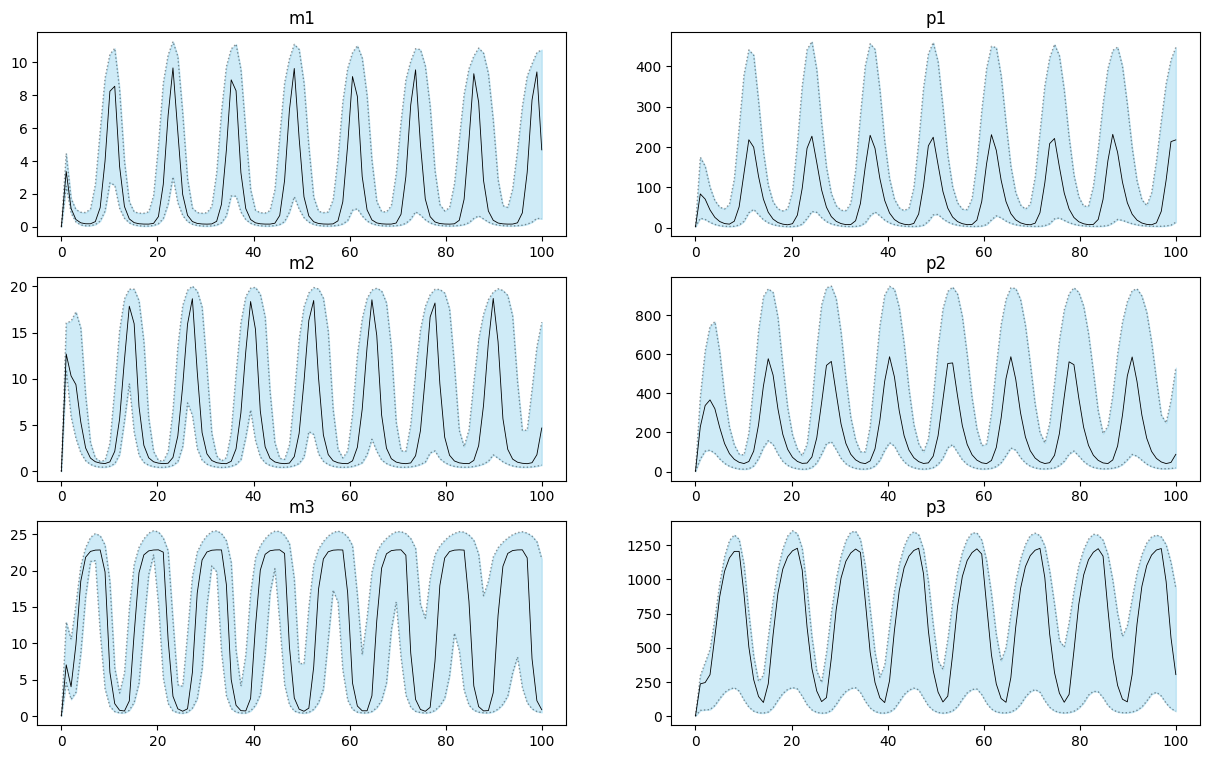

In [17]:
ppc(param_vals_15p_sumstats,"15p_summary_statistics")

In [17]:
def pairplot(params,true_vals,title):
    num_params=np.shape(params)[1]
    fig, ax = plt.subplots(num_params, num_params, figsize=(num_params*3, num_params*3))
    sns.set_style("white")
    for i in range(num_params):
        for j in range(num_params):
            if i != j:
                sns.kdeplot(x=params.iloc[:, j], y=params.iloc[:, i], ax=ax[i, j], cmap="Blues", fill=True)
                ax[i, j].scatter(x=true_vals[j],y=true_vals[i], marker="x", s=150, color="salmon",linewidths=4)
                ax[i, j].set_ylabel(params.columns[i])
            else:
                sns.histplot(params.iloc[:, i], ax=ax[i, j], kde=True, color="skyblue")
                ax[i, j].axvline(true_vals[i], color="salmon",linewidth=4)
            ax[i, j].set_xlabel(params.columns[j])
            #ax[i, j].set_title(params.columns[i])
    plt.tight_layout()
    plt.savefig(f"{title}_pairplot.png",dpi=700)
    plt.show()

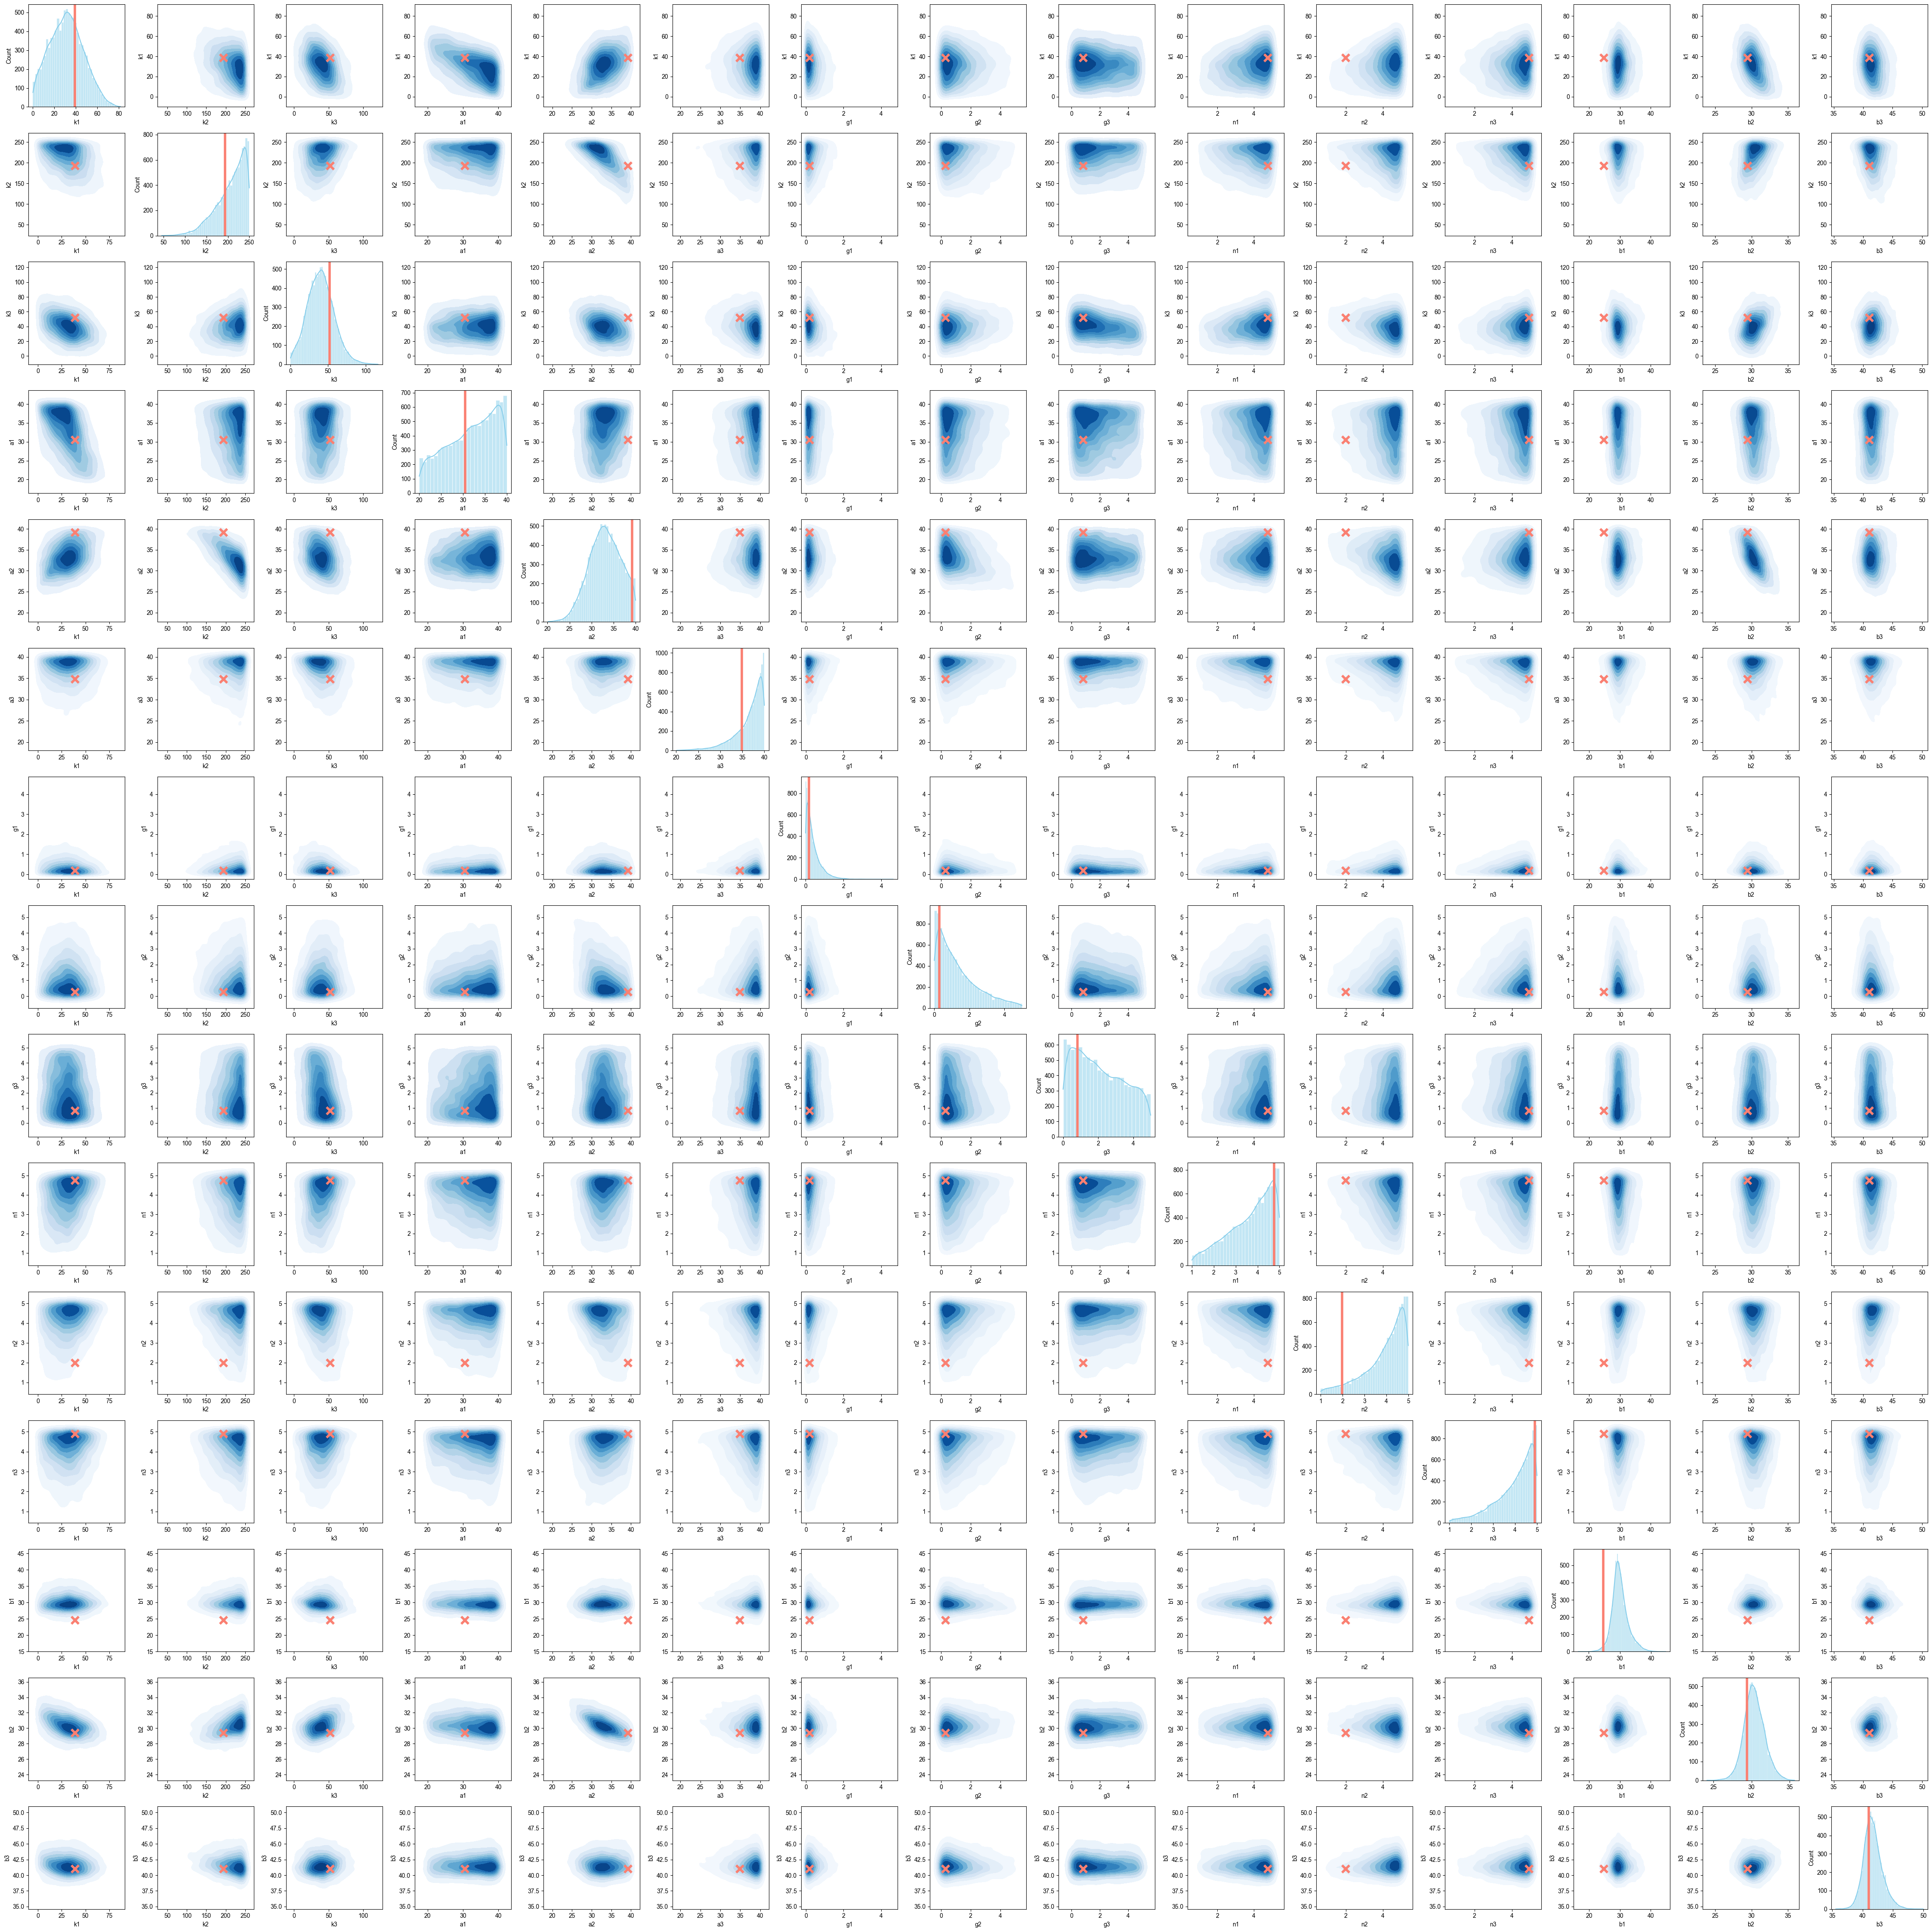

In [18]:
pairplot(param_vals_15p_flattened,true_vals[:15],"15p_flattened")

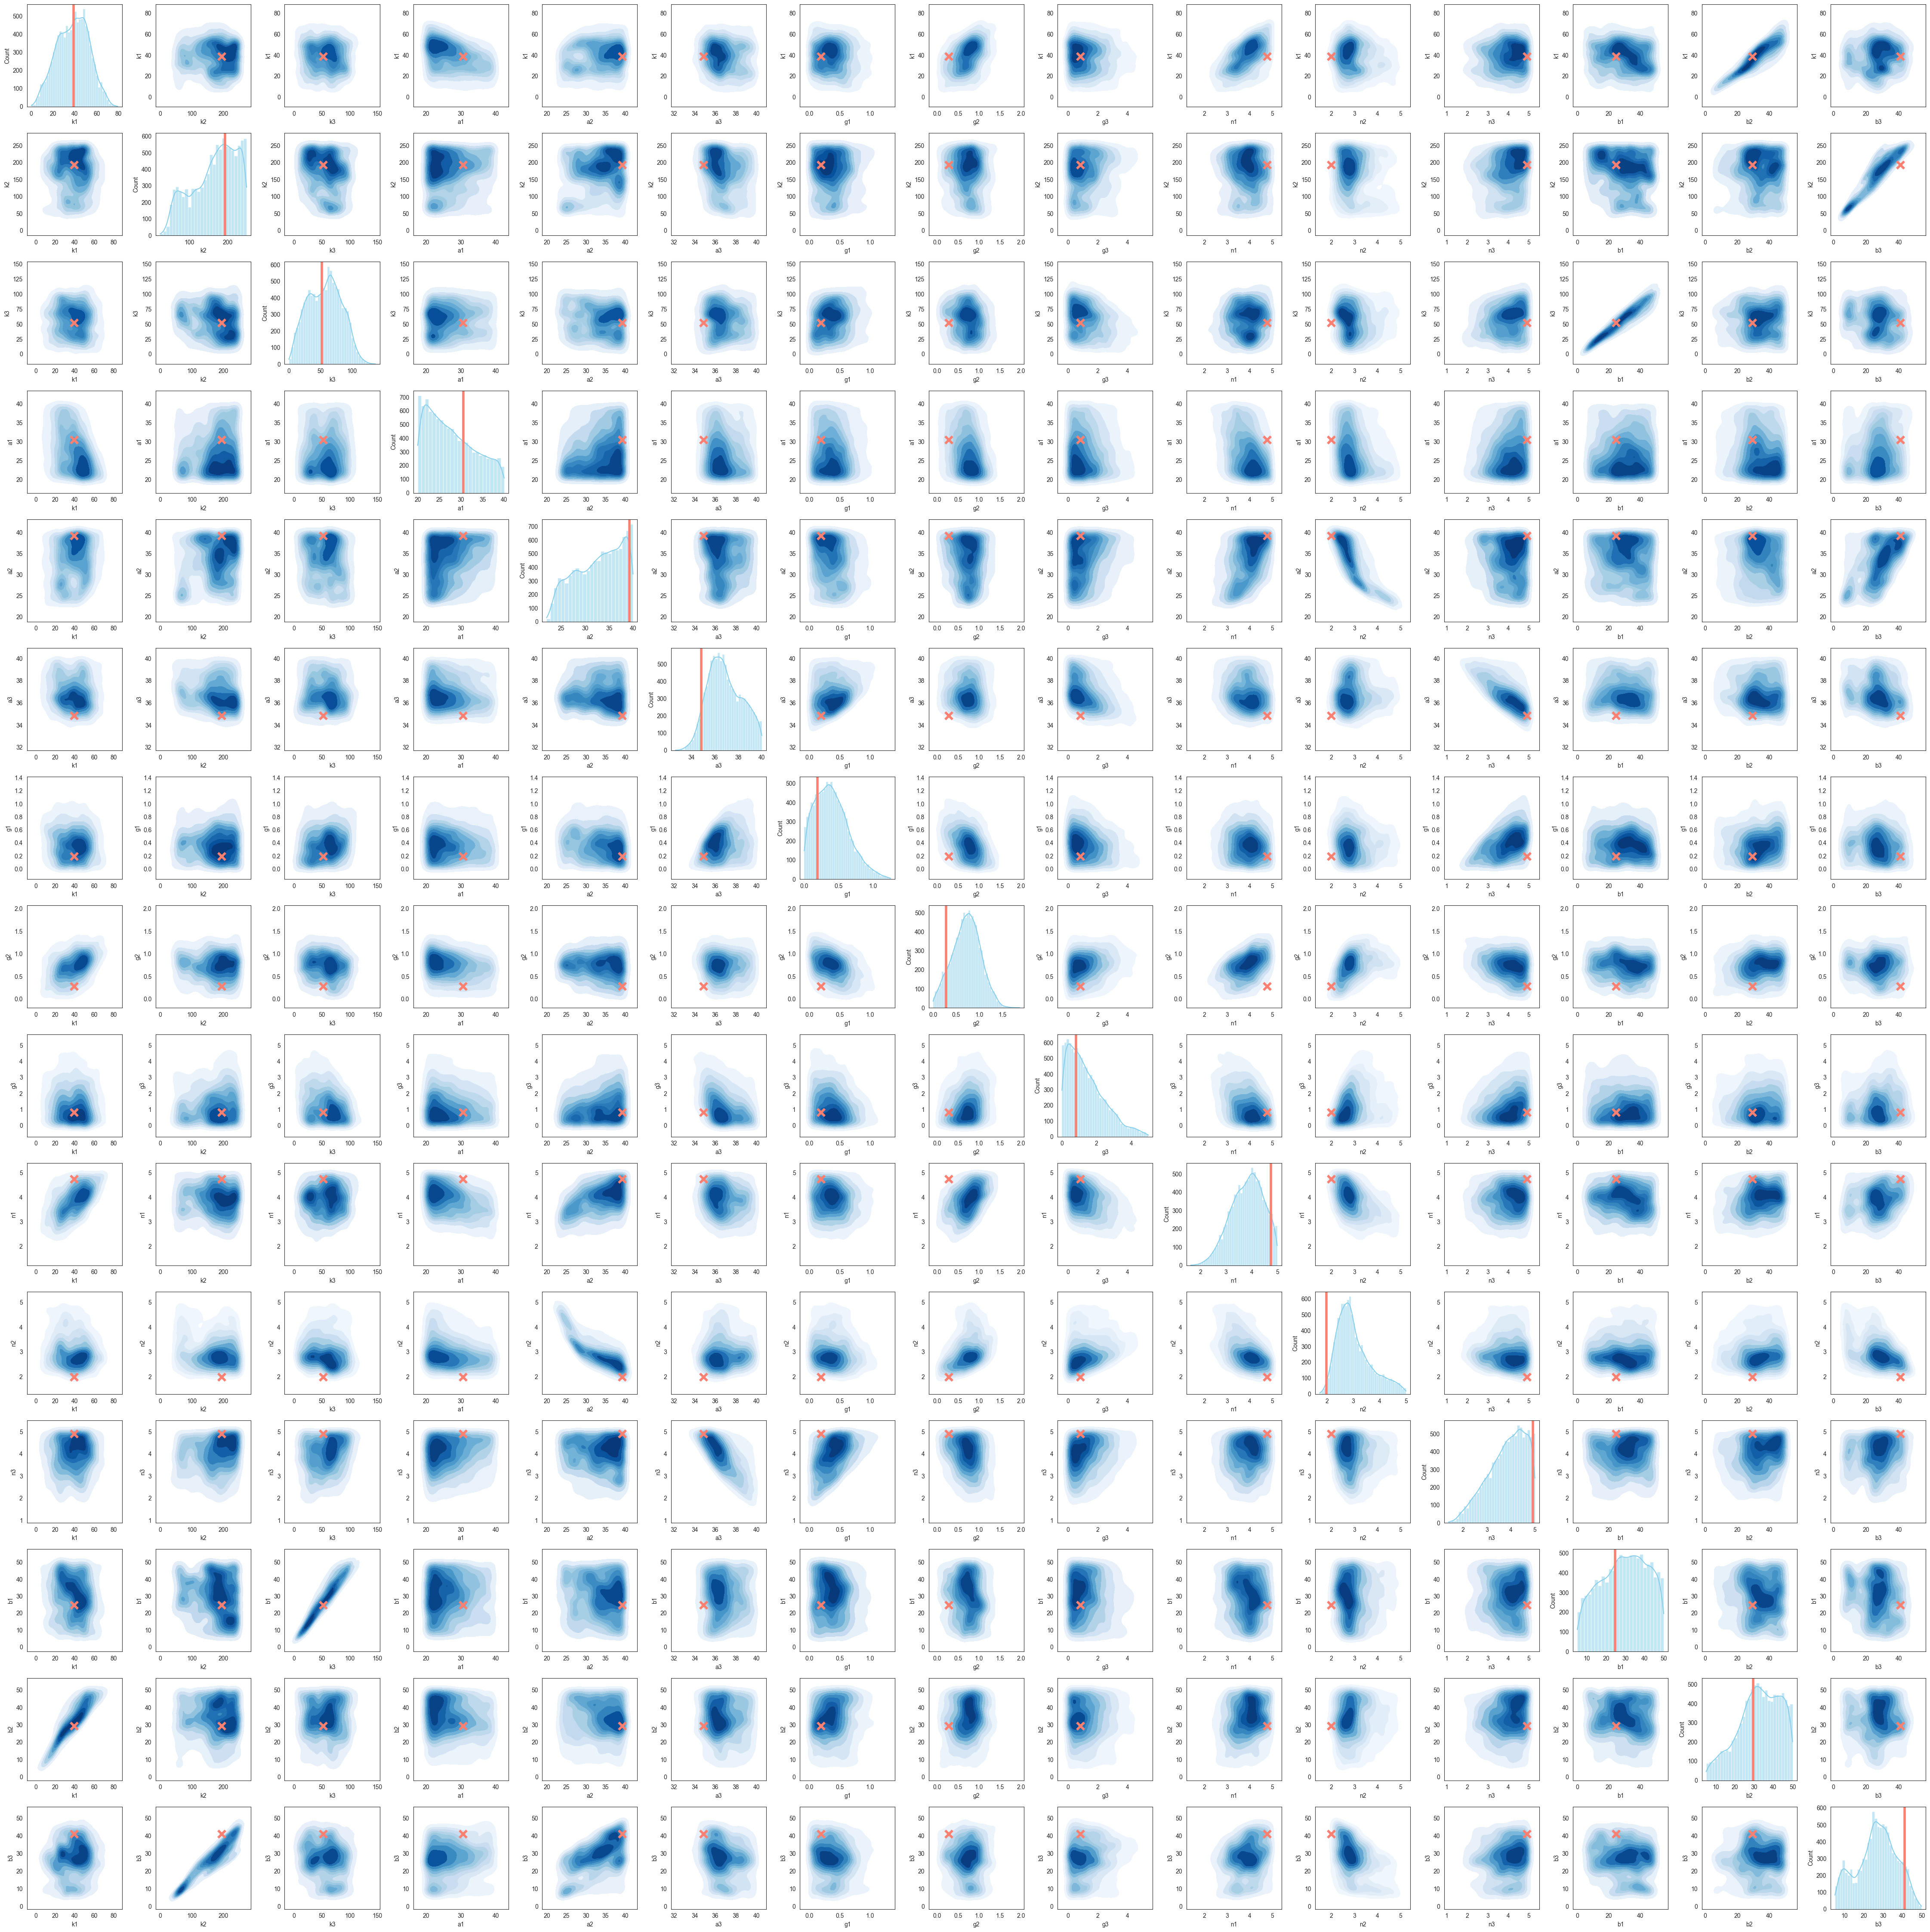

In [19]:
pairplot(param_vals_15p_sumstats,true_vals[:15],"15p_summary_statistics")